# Segmentación basada en grafos
Universidad de Chile  
Departamento de Ciencias de la Computación  
CC5508 - Procesamiento y Análisis de Imágenes  
Gabriel De La Parra  

## Introducción
Esta tarea se basa en la implementación del paper *[Efficient Graph-Based Image Segmentation](https://cs.brown.edu/~pff/papers/seg-ijcv.pdf)* de *[Pedro F. Felzenzswalb](https://cs.brown.edu/~pff/)*. 

##### Imágen como grafo
En la investigación se expone una técnica de *[segmentación de imagenes](https://en.wikipedia.org/wiki/Image_segmentation)* utilizando un *[grafo no dirigido](https://es.wikipedia.org/wiki/Grafo#Grafo_no_dirigido)* para representar la imagen de entrada:
* Los nodos del grafo representan los pixeles de la imagen. 
* Los arcos del grafo representan la relación entre pixeles vecinos.
* A cada arco se le asocia un peso. De lo anterior, cada peso determina la relación entre pixeles vecinos.

##### Segmentación
La segmentación consiste en generar conjuntos de nodos (o componentes conexas).

Para lo anterior se definen dos métricas:
* *Diferencia interna de una componente conexa*.
* *Diferencia entre dos componentes conexas*. 

Lo anterior pretende agrupar pixeles en regiones que sean similares entre sí y diferentes a otras regiones.

##### Proceso de la segmentación
Para la segmentación se procede de la siguiente manera:
* Con las métricas anteriores, se itera sobre las fronteras de cada componente.
* Sobre dicha frontera se busca evaluar si (los pesos de) la *diferencia entre las componentes* es suficientemente mayor a (los pesos de) la *diferencia interna* (de cada componente).
* A partir de esta evaluación se puede generar una única región o mantener las dos regiones.

Para mejorar este proceso se define un umbral sobre la evaluación de las diferencias.

Lo anterior se realiza para todos los arcos del grafo.

##### Métricas para la segmentación
La *diferencia entre dos componentes* se define como el peso mínimo a lo largo de (los arcos de) la frontera entre los dos grupos de nodos.

Por su parte, *la diferencia interna*, se define como el peso máximo en el MST de la componente.

Un MST (*[minumum spanning tree](https://en.wikipedia.org/wiki/Minimum_spanning_tree)* o *[árbol cobertor mínimo](https://es.wikipedia.org/wiki/%C3%81rbol_recubridor_m%C3%ADnimo)*) es una estructura de datos que permite ordenar todos los nodos de un grafo.

[![Minimum spanning tree](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d2/Minimum_spanning_tree.svg/300px-Minimum_spanning_tree.svg.png)](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d2/Minimum_spanning_tree.svg/300px-Minimum_spanning_tree.svg.png)

> Un ejemplo de árbol recubridor mínimo. Cada punto representa un vértice, cada arista está etiquetada con su peso, que en este caso equivale a su longitud. - Wikipedia

Una forma de construir un MST (Hint entregado en el enunciado) es por el método de [Kruskal](https://es.wikipedia.org/wiki/Algoritmo_de_Kruskal). Para esto se requiere ocupar un algoritmo eficiente para determinar:

1. Los componentes que conectan una arista (Find).
2. Mezclar o unir dos componentes (Union). 

#### Union-Find
[Union-Find](https://en.wikipedia.org/wiki/Disjoint-set_data_structure) es un algoritmo para estructuras de datos disjuntas. *Una estructura de datos para conjuntos disjuntos, es una estructura de datos que mantiene un conjunto de elementos particionados en un número de conjuntos disjuntos (no se solapan los conjuntos).* 

*Union*: Une dos subconjuntos en uno solo.

*Find*: Determina a cual subconjunto pertenece un elemento. Esta operación puede usarse para verificar si dos elementos están en el mismo conjunto.

La [complejidad del algoritmo](https://en.wikipedia.org/wiki/Disjoint-set_data_structure#Time_Complexity) se diferencia por 4 formas de implementación:
* *Union* con *Union-by-rank*
* *Find* con *path compression*
* Ambas
* Ninguna

*Union-by-rank*, consiste en añadir el árbol más pequeño a la raíz del árbol más grande. Como la profundidad del árbol afecta el tiempo de ejecución del algoritmo, el árbol con menor profundidad es añadido a la raíz del árbol con mayor profundidad, el cual aumenta su profundidad solo si sus profundidades son iguales.

*Find* con *path compression*, es una forma recursiva de aplanar la estructura del árbol. Cada nodo visitado en el camino hacia la raíz se añade directamente a la raíz ya que todos estos nodos la comparten. El árbol resultante es más aplanado, acelerando operaciones futuras no solo en estos elementos sino también en aquellos que referencian a estos.

#### Indicaciones de la tarea
Para esta tarea se solicita implementar el algoritmo de segmentación de Felzenswalb para imagenes a colores (3 canales). Una restricción dada, es que no se permite convertir la imagen a escala de grises. Adicionalmente se solicita implementar esto para distintos espacios de color: RGB y CIE L\*a\*b. Finalmente se solicita ejecutar esto para 10 imágenes distintas y comparar los resultados.

Dado lo anterior, en el Paper se indica como trabajar en este tipo de casos:
* Construir el grafo con conectividad 8.
* Utilizar una función de pesos basada en la intensidad absoluta entre pixeles:

<center>$w(v_i, v_j) = |I(p_i)-I(p_j)|$</center>

donde:

$w(v_i, v_j)$ es la función de pesos sobre los nodos $v_i$ y $v_j$

$I(p_i)$ y $I(p_j)$ es la intensidad de los pixeles $p_i$ y $p_j$

Adicionalmente:

* Se aplica un filtro Gaussiano, con $\sigma$ recomendado de $0.8$, que no produce cambios perceptibles en la imagen.
* Para imágenes en color, se ejecuta el algoritmo 3 veces, una para cada componente del espacio de color y luego se intersectan los 3 conjuntos. Para esto se colocan 2 pixeles vecinos en la misma componente si aparecen en las 3 componentes de color. Alternativamente, se propone ejecutar el algoritmo una sola vez, tomando los pesos como la distancia entre los pixeles en el espacio de color.

La propuesta del autor es mucho más sencilla para trabajar en distintos espacios de color.

In [90]:
#class Edge:
#    def __init__(self):
#        self.node1 = 0
#        self.node2 = 0
#        self.weight = 0

In [80]:
%matplotlib inline

import os
from scipy import ndimage as ndi
from skimage import io, morphology, filters, exposure, measure, segmentation, color, img_as_float
import matplotlib.pylab as plt
import matplotlib
import numpy as np
from ipywidgets import interact, widgets, HBox
from IPython import display

#Ajustar el tamaño de las imágenes:
matplotlib.rcParams['figure.figsize'] = (14,12)

In [95]:
selectImageWidget = widgets.ToggleButtons(
    options=[f for f in os.listdir(os.getcwd()) if f.endswith('.jpg')],
    description='Image:',
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
)

colorSpaceWidget = widgets.ToggleButtons(
    options=['RGB', 'CIE LAB', 'CIE LUV', 'HSV', 'RGB CIE', 'XYZ'],
    description='Color Space:',
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
)

sigmaWidget = widgets.FloatSlider(
    value=0.1,
    min=0,
    max=2,
    step=0.1,
    description='Sigma:',
    continuous_update=False,
    readout=True,
    readout_format='.1f',
)

class Edge:
    def __init__(self):
        self.vertex1 = 0
        self.vertex2 = 0
        self.weight = 0

def thresholdFunction(size, k):
    return k / size

def segmentGraph(numberOfVertices, numberOfEdges, edges, k):
    # Sort edges by weight
    edges = sorted(edges, key=lambda edges: edges.weight)

    # Make a disjoint-set forest
    sets = Set(numberOfVertices)

    # Initialize thresholds (size=1)
    threshold = np.zeros(numberOfVertices)
    for i in range(numberOfVertices):
        threshold[i] = thresholdFunction(1, k)

    # For each edge (non-decreasing order)
    for i in range(numberOfEdges):
        # Vertices connected by this edge
        vertex1 = sets.find(edges[i].vertex1)
        vertex2 = sets.find(edges[i].vertex2)
        # If they belong to different components
        if (vertex1 != vertex2):
            # Check if they need to be joined (and do it)
            if (edges[i].weight <= threshold[vertex1]) and (edges[i].weight <= threshold[vertex2]):
                sets.join(vertex1, vertex2)
                vertex1 = sets.find(vertex1)
                threshold[vertex1] = edges[i].weight + thresholdFunction(sets.size(vertex1), k)

    return sets

def euclideanDistance(image, x1, y1, x2, y2):
    return sqrt(pow(image[y1][x1][0] - image[y2][x2][0], 2) + pow(image[y1][x1][1] - image[y2][x2][1], 2)
                + pow(image[y1][x1][2] - image[y2][x2][2], 2))

def createGraph(image, sigma, k, minimumSize):
    width = image.shape[1]
    height = image.shape[0]
    h, w = image.shape

    # Initialize edges
    edges = [Edge() for i in range(width * height * 4)]
    number = 0
    for y in range(height):
        for x in range(width):
            if x < width - 1:
                edges[number].vertex1 = y * width + x
                edges[number].vertex2 = y * width + (x + 1)
                edges[number].weight = euclideanDistance(image, x, y, x + 1, y)
                number += 1

            if y < height - 1:
                edges[number].vertex1 = y * width + x
                edges[number].vertex2 = (y + 1) * width + x
                edges[number].weight = euclideanDistance(image, x, y, x, y + 1)
                number += 1

            if x < width - 1 and y < height - 1:
                edges[number].vertex1 = y * width + x
                edges[number].vertex2 = (y + 1) * width + (x + 1)
                edges[number].weight = euclideanDistance(image, x, y, x + 1, y + 1)
                number += 1

            if x < width - 1 and y > 0:
                edges[number].vertex1 = y * width + x
                edges[number].vertex2 = (y - 1) * width + (x + 1)
                edges[number].weight = euclideanDistance(image, x, y, x + 1, y - 1)
                number += 1
                
    sets = segmentGraph(width * height, number, edges, k)

    # Process components smaller than the minimum size
    for i in range(number):
        a = sets.find(edges[i].vertex1)
        b = sets.find(edges[i].vertex2)
        if a != b and (sets.size(a) < minimumSize or sets.size(b) < minimumSize):
            sets.join(a, b)

    output = np.zeros((height, width, 3))

    # Generate random colors for components
    colors = np.zeros((3, (width * height)))
    for i in range(width * height):
        for j in range(3):
            colors[j][i] = randint(0, 255)

    for y in range(height):
        for x in range(width):
            comp = sets.find(y * width + x)
            for z in range(3):
                output[y][x][z] = colors[z][comp]

    return output

def loadImage(imageFile, colorSpace, sigma):
    image = exposure.rescale_intensity(img_as_float(io.imread(imageFile)))
    if colorSpace=="CIE LAB":
        image = exposure.rescale_intensity(color.rgb2lab(image))
    elif colorSpace=="CIE LUV":
        image = exposure.rescale_intensity(color.rgb2luv(image))
    elif colorSpace=="HSV":
        image = exposure.rescale_intensity(color.rgb2hsv(image))
    elif colorSpace=="RGB CIE":
        image = exposure.rescale_intensity(color.rgb2rgbcie(image))
    elif colorSpace=="XYZ":
        image = exposure.rescale_intensity(color.rgb2xyz(image))
    
    image = filters.gaussian(image, sigma, multichannel=True)
    
    image2 = createGraph(image, sigma, 0.7, 200)
    
    plt.imshow(image, cmap="gray")
    plt.show()


    
interact(loadImage, imageFile = selectImageWidget, colorSpace = colorSpaceWidget, sigma = sigmaWidget)

<function __main__.loadImage>

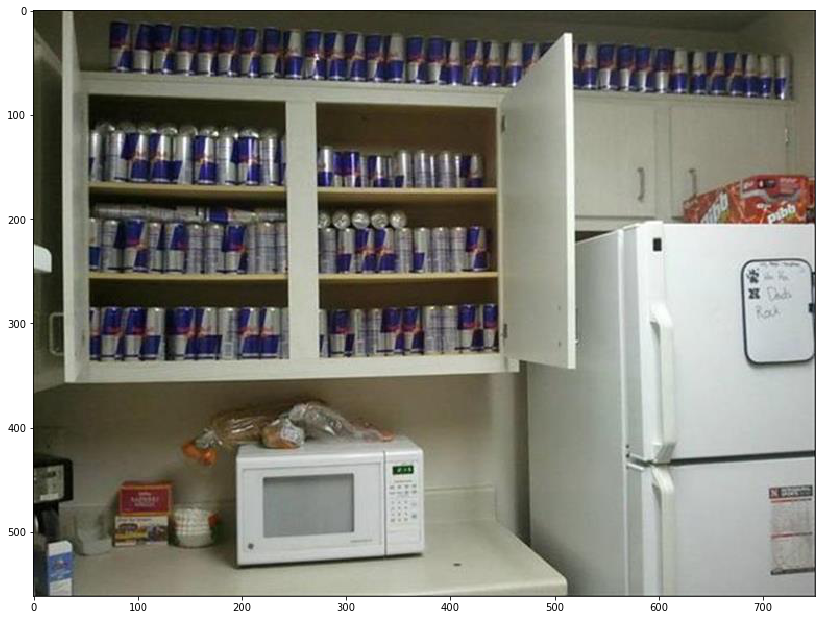

In [89]:
plt.imshow(coloredImage)
plt.show()

## Desarrollo

##### Detalles del algoritmo
Para la segmentación se propone el siguiente algoritmo:
1. Ordenar los arcos por sus pesos, de menor a mayor.
2. Definir una segmentación inicial, en la que cada primer nodo es una componente por si sola.
3. Para cada arco:
    * Construir una componente nueva a partir de la componente anterior:
        * Si los dos nodos no pertenecen a la misma componente anterior y el peso entre ellos  es bajo, comparado con la diferencia entre las dos componentes, unir las componentes. Si no, continua.
4. Repetir 3. para todos los arcos del grafo.


#### Aplicaciones de la segmentación (Conc)
La investigación parte con la necesidad de tener algoritmos eficientes para segmentación de imágenes. Algunas de las aplicaciones que se mencionan son los problemas de dificultad media como reconocimiento estéreo, en donde son necesarias definir  *region of support* para las operaciones de correspondencia. Dichas regiones pueden ser encontradas con algoritmos de segmentación. Los problemas de alto nivel también pueden beneficiarse con algoritmos que sirvan para diferenciar el fondo de los objectos y el reconocimiento de las distintas partes.


#### Características deseadas de la segmentación (Conc)
Según el autor, un algoritmo de segmentación debe ser capaz de: 
1. *Capturar regiones o grupos de importancia perceptual que reflejan aspectos globales de la imagen*. Sobre esto, dos problemas principales son poder caracterizar aquello que es importante de la imagen y especificar que es lo que hace una determinada técnica de segmentación.
2. *Ser eficiente, funcionar en tiempo linear sobre el número de pixeles de una imágen*. Los métodos de segmentación deben funcionar a la par con los métodos de detección de borde u otros algoritmos de bajo nivel.


#### Métodos existentes (conc)
En la época en que se escribió esta investigación, se analizaron otras técnicas existentes. El documento explica como los procesos basados en vectores propios son muy lentos para aplicaciones prácticas. Adicionalmente se menciona que otros métodos, si eficientes, fallan en capturar las propiedades globales (no-locales) de la imágen que son perceptiblemente importantes.